# Learning a Graph Edit Distance using Siamese GNNs

## Configurations

Configurations are done in OmegaConf and found for the Synthethic GED task under `./config_ged.yaml`. </br>
Let's load and print them:

In [1]:
import torch
from omegaconf import OmegaConf

# Set device type (CUDA is prefered)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Configurations
cfg = OmegaConf.load("config_ged.yaml")
cfg.model.node_has_features = False
cfg.model.edge_has_features = False
# cmd_cfg = OmegaConf.from_cli()
# cfg = OmegaConf.merge(cfg, cmd_cfg)
print(OmegaConf.to_yaml(cfg))

model:
  node_dim: 32
  edge_dim: 32
  inter_geom_dim: none
  graph_dim: 128
  num_layers: 5
  type: matching
  layer_norm: true
  similarity: dot
  linear: residual
  message_gain: 0.1
  node_update_type: gru
  node_has_features: false
  edge_has_features: false
optimize:
  cuda: true
  distance: margin
  margin: 1
  n_iterations: 500000
  lr: 0.0001
  batch_size: 20
data:
  kp: 1
  kn: 2
  pe: 0.2
  num_nodes: 20



## Data

See notebook "NB_graphs.ipynb" on how to set up the graph edit distance dataset **in Pytorch Geometric**. </br>
In summary, we do the following: </br>

$\bullet$ Triplets are mined by sampling random binomial graphs $G1$; </br>
$\bullet$ Given $G_1$, we modify it to $G_2$ (the positive) by substituting $k_p$ edges; </br>
$\bullet$ Similarly, we create $G_3$ (the negative) by substituting $k_n$ edges; </br>
$\bullet$ They are combined into a bigger disjoint union as $\text{join}([G_1, G_2, G_1, G_3])$; </br>
$\bullet$ We use a simple pytorch geometric dataset class to combine them into graph batches.

In [2]:
from torch_geometric.loader import DataLoader
from data import TripletDatasetGED

# Load dataset and initialize data loader in PyG.
# Permuting the nodes should be set to False for plotting. (When training, it should be made
dataset = TripletDatasetGED(num_nodes=8, kp=cfg.data.kp, kn=cfg.data.kn, pe=cfg.data.pe, permute=False)
dataloader = DataLoader(dataset, batch_size=cfg.optimize.batch_size, shuffle=True)

Let's plot a batch of graphs. </br>
A triplet is plotted on each row: $G_1$, $G_2$, $G_1$, $G_3$. </br>
Red edges (in $G_1$) are the ones substituted by green edges (in $G_2$ and $G_3$). </br>
The nodes are positioned (in terms of coordinates) the same for $G_1$, $G_2$, and $G_3$. </br>
This means that sometimes the (new) edges in $G_2$ and/or $G_3$ are crossing other nodes.

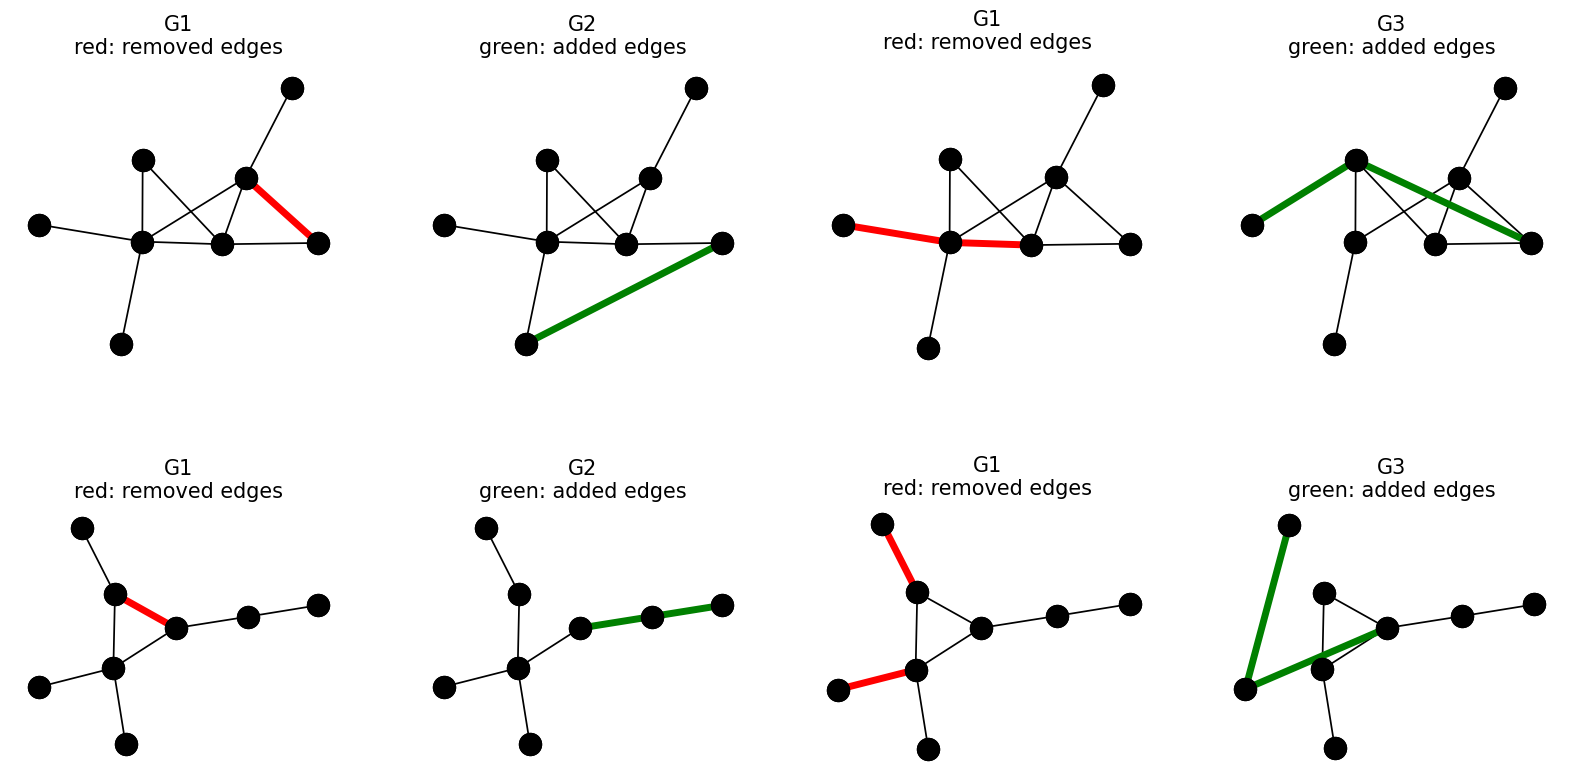

In [3]:
from torch_geometric.utils import to_networkx
from plot import plot_graph_batch

# Sample a batch and convert to NetworkX
batch = next(iter(dataloader))  # sample first batch
batch = to_networkx(batch, node_attrs=["order", "batch"], to_undirected=True)  # batch as NetworkX graph

# Plot the batch
num_samples = 2  # should be lower than batch size (default bs = 20)
nc = ec = "black"
bc = "white"
plot_graph_batch(batch, num_samples, fs=5, fs_title=3, pos_type="kamada",
                 node_color=nc, edge_color=ec, background=bc, set_title=True)

To make it visually more appealing and easier to understand,  we have used rather small graphs ($N=8$) here. </br>
During training, on the other hand, we will use often much bigger graphs (*eg*, $N \in [20, 50]$).

## Forward pass

Now, we implement a forward pass. </br>
We use two **models**:

$\bullet$ Graph embedding network (GEN); </br>
$\bullet$ Graph matching network (GMN).

Both models share the same graph encoder (simple MLPs) and propagation layers (message passing networks). </br>
The GMN uses an extra cross-graph information sharing module to explicitly model node-to-node correspondences in each propagation layer.

In [4]:
from model import GraphMatchingNetwork

model = GraphMatchingNetwork(cfg)
print(model)

GraphMatchingNetwork(
  (encoder): GraphEncoder()
  (conv_layers): ModuleList(
    (0): GMNConv()
    (1): GMNConv()
    (2): GMNConv()
    (3): GMNConv()
    (4): GMNConv()
  )
  (aggregator): GraphAggregator(
    (lin): Linear(in_features=32, out_features=128, bias=True)
    (lin_gate): Linear(in_features=32, out_features=128, bias=True)
    (lin_final): Linear(in_features=128, out_features=128, bias=True)
  )
)


Let's now prepare the data, such that it is compatible with the network's architecture:

In [5]:
# Sample batch
batch = next(iter(dataloader))

# Number of nodes and edges in batch
num_nodes = batch.num_nodes
num_edges = batch.num_edges

# Prepare the data
edge_index = batch['edge_index']  # edge index
node_feats = torch.ones(num_nodes, cfg.model.node_dim)  # node features to all-ones
edge_feats = torch.ones(num_edges, cfg.model.edge_dim)  # edge features to all-ones
batch_id = batch['order'] + 4 * batch['batch']

# Print some information
print(f"Number of edges:\t\t{len(edge_index)}\n"
      f"Shape node features:\t{node_feats.shape}\n"
      f"Shape edge features:\t{edge_feats.shape}\n"
      f"Batch IDs:\t\t\t\t{batch_id}")

Number of edges:		2
Shape node features:	torch.Size([640, 32])
Shape edge features:	torch.Size([1304, 32])
Batch IDs:				tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,
         2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,
         4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,
         6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,
         9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11,
        11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13,
        13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15,
        15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17,
        18, 18, 18, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20,
        20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21, 22, 22, 22, 22,
        22, 22, 22, 22, 23, 23, 23, 23, 23, 23, 23, 23, 24, 24, 24, 24, 24, 24,

Now we can do the forward pass:

In [6]:
# Forward pass
_, graph_feats = model(edge_index, x1=node_feats, x2=None, edge_feats=edge_feats, batch=batch_id)

# Print some information
print(f"Shape graph level representation:\t{graph_feats.shape}")

Shape graph level representation:	torch.Size([80, 128])


That's correct. Given a batch size of 20, and 4 graphs per triplet, we expect indeed 80 graphs.

## Compute the loss

We use a **triplet loss** to train the model. </br>
For this to work, we need to first split and reshape the tensors. </br>
The output of that is the input to the loss.

In [7]:
from loss import triplet_loss
from utils import reshape_and_split_tensors
from metrics import euclidean_distance

# Forward pass
_, graph_feats = model(edge_index, x1=node_feats, x2=None, edge_feats=edge_feats, batch=batch_id)

# Reshape and split tensors
graph_feats = reshape_and_split_tensors(graph_feats, 4)

# Compute loss
losses = triplet_loss(*graph_feats, cfg)
loss = losses.mean()

# Compute distances
distances_12 = euclidean_distance(graph_feats[0], graph_feats[1])
distances_13 = euclidean_distance(graph_feats[2], graph_feats[3])
rel_distances = distances_12 - distances_13

# Compute correctly classified ones
corrects = torch.sum(rel_distances < 0)

# Print some information
print(f"Distances G1 > G2:\n\t{distances_12}\n"
      f"Distances G1 > G3:\n\t{distances_13}\n"
      f"Relative distances:\n\t{rel_distances}"
      f"Number of corrects:\n\t{corrects}")

Distances G1 > G2:
	tensor([0.0113, 0.0224, 0.0120, 0.0081, 0.0155, 0.0083, 0.0078, 0.0134, 0.0063,
        0.0123, 0.0078, 0.0075, 0.0103, 0.0140, 0.0263, 0.0106, 0.0180, 0.0069,
        0.0132, 0.0088], grad_fn=<SumBackward1>)
Distances G1 > G3:
	tensor([0.0141, 0.0133, 0.0062, 0.0144, 0.0086, 0.0076, 0.0037, 0.0086, 0.0112,
        0.0145, 0.0061, 0.0122, 0.0096, 0.0056, 0.0072, 0.0066, 0.0050, 0.0109,
        0.0142, 0.0123], grad_fn=<SumBackward1>)
Relative distances:
	tensor([-0.0028,  0.0091,  0.0058, -0.0063,  0.0068,  0.0007,  0.0041,  0.0048,
        -0.0049, -0.0021,  0.0017, -0.0047,  0.0006,  0.0084,  0.0191,  0.0040,
         0.0130, -0.0040, -0.0010, -0.0034], grad_fn=<SubBackward0>)Number of corrects:
	8


## Training

Initialize W&B

In [8]:
import wandb

wandb.login()
wandb.Api(api_key='c52c284e0d6ab885356b0f83dd3725d320154b96')

wandb: Currently logged in as: casper-van-engelenburg. Use `wandb login --relogin` to force relogin


Training script

In [9]:
from utils import AverageMeter
from tqdm.auto import tqdm

# Checkpoint path
path_models = r'./checkpoints'

def train(model, optimizer, train_loader, cfg, device='cpu', print_freq=25):

      model.train().to(device)

      train_loss = AverageMeter()
      train_accs = AverageMeter()

      # Initialize best loss and acc (by dummies)
      best_loss = 1

      # loop through training batch
      for i, batch in tqdm(enumerate(train_loader), total=len(train_loader)):

            # Prepare data
            # Number of nodes and edges in batch
            num_nodes = batch.num_nodes
            num_edges = batch.num_edges

            # Prepare the data
            edge_index = batch['edge_index']  # edge index
            node_feats = torch.ones(num_nodes, cfg.model.node_dim)  # node features to all-ones
            edge_feats = torch.ones(num_edges, cfg.model.edge_dim)  # edge features to all-ones
            batch_id = batch['order'] + 4 * batch['batch']

            # Feedforward
            _, graph_feats = model(edge_index, x1=node_feats, x2=None, edge_feats=edge_feats, batch=batch_id)
            graph_feats = reshape_and_split_tensors(graph_feats, 4)

            losses = triplet_loss(*graph_feats, cfg)
            loss = losses.mean()
            train_loss.update(loss.item())

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # get accuracy measure
            rel_distance = euclidean_distance(graph_feats[0], graph_feats[1]) \
                       - euclidean_distance(graph_feats[2], graph_feats[3])
            corrects = torch.sum(rel_distance < 0)
            train_accs.update(corrects.item() / cfg.optimize.batch_size)

            # print
            metrics = {}

            if i % print_freq == print_freq - 1:

                  # Print some information
                  print(f"[Iter={i+1}/{len(train_loader)}] -- "
                        f"Train loss = {train_loss.avg:3.6f} -- "
                        f"Train acc = {train_accs.avg:3.3f}")

                  # Save metrics
                  metrics["loss"] = train_loss.avg
                  metrics["accuracy"] = train_accs.avg
                  wandb.log({**metrics})

                  train_loss = train_loss.avg
                  train_acc = train_accs.avg
                  if train_loss < best_loss:  # best model is based on loss
                        best_loss = train_loss

                        name_save = os.path.join(path_models, f'{cfg.model.name}_{wandb.run.name}')

                        state = {
                              'state_dict': model.state_dict(),
                              'best_loss': train_loss,
                              'best_acc': train_acc,
                              'optimizer': optimizer.state_dict(),
                              'config': cfg
                        }

                        # save best model so far
                        save_checkpoint(state, name_save)

                  # Reset train losses and accuracy
                  train_loss = AverageMeter()
                  train_accs = AverageMeter()

      return train_loss.avg, train_accs.avg

Now, we can go training:

In [ ]:
import os
from torch.optim import Adam
from utils import save_checkpoint
from model import GraphConvolutionNetwork

# Initialize lists of information
train_losses = []
train_accuracies = []

# Set dataset and loader
size = cfg.optimize.batch_size * cfg.optimize.n_iterations
dataset = TripletDatasetGED(size=size, num_nodes=8,
                            kp=cfg.data.kp, kn=cfg.data.kn, pe=cfg.data.pe,
                            permute=True)
dataloader = DataLoader(dataset, batch_size=cfg.optimize.batch_size, shuffle=True)

# Set model
model = GraphConvolutionNetwork(cfg)
cfg.model.name = 'gcn'

# Set optimizer
optimizer = Adam(model.parameters(), lr=cfg.optimize.lr)

# Set project W&B
wandb.init(entity='casper-van-engelenburg',
           project="graph matching networks",
           config=OmegaConf.to_container(cfg, resolve=True, throw_on_missing=True))

# Train
train_loss, train_acc = train(model, optimizer, dataloader, cfg, print_freq=25)

accuracy,▁▄▆▆▄▇▆███▇▇▇▇▇█████████████████████████
loss,█▅▃▃▅▃▃▂▁▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,1.0
loss,0.0


  0%|          | 0/500000 [00:00<?, ?it/s]

[Iter=25/500000] -- Train loss = 0.996220 -- Train acc = 0.380
[Iter=50/500000] -- Train loss = 0.995654 -- Train acc = 0.374
[Iter=75/500000] -- Train loss = 0.975536 -- Train acc = 0.374
[Iter=100/500000] -- Train loss = 0.990872 -- Train acc = 0.346
[Iter=125/500000] -- Train loss = 0.995264 -- Train acc = 0.346
[Iter=150/500000] -- Train loss = 0.998698 -- Train acc = 0.316
[Iter=175/500000] -- Train loss = 0.999311 -- Train acc = 0.296
[Iter=200/500000] -- Train loss = 0.999874 -- Train acc = 0.346
[Iter=225/500000] -- Train loss = 0.999996 -- Train acc = 0.308
[Iter=250/500000] -- Train loss = 1.000989 -- Train acc = 0.292
[Iter=275/500000] -- Train loss = 1.000536 -- Train acc = 0.298
[Iter=300/500000] -- Train loss = 1.000159 -- Train acc = 0.310
[Iter=325/500000] -- Train loss = 1.000159 -- Train acc = 0.316
[Iter=350/500000] -- Train loss = 0.997847 -- Train acc = 0.336
[Iter=375/500000] -- Train loss = 1.000955 -- Train acc = 0.272
[Iter=400/500000] -- Train loss = 0.996326 